In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader

from binarypredictor import split_functions
from binarypredictor.dataset import FunctionPairDataset
from binarypredictor.net import DerivativeNet, TangentNet

In [2]:
out_features = 500
in_features = out_features

In [3]:
net_0 = DerivativeNet(train=False, net='FirstDerivativeNet_250_s.pth')
net_1 = DerivativeNet(train=False, net='SecondDerivativeNet_250_s.pth')

In [4]:
fpd = FunctionPairDataset(n_functions=100, filename="test_.csv", overwrite=True, step=1/in_features)
fpd.create_functions()

In [6]:
loader = DataLoader(fpd, batch_size=1028)
net = TangentNet(train=True, in_features=in_features * 2, out_features=out_features, hidden_size_linear=500, hidden_layers=2)

In [5]:
x = torch.arange(1e-10, 1., step=fpd.step)

In [8]:
lr = 1e-3

# Workers
loss_func = nn.L1Loss()  #nn.MSELoss()
optimizer = Adam(net.parameters(), lr=lr)

best_loss = 1000
best_net = net

for i in range(7500):
    for d in loader:
        inp = torch.hstack((d[0][:, :, 0], d[0][:, :, 1]))
        out = net(inp)
        out = torch.clamp(out, min=1e-10, max=1.-1e-4)
        
        f_ = fpd.base_function(**d[1][0], x=out)/d[2].unsqueeze(-1)
        g_ = d[0][:, :, 1]/d[2].unsqueeze(-1)
        f_der = fpd.first_derivative(**d[1][0], x=out)/d[2].unsqueeze(-1)
        g_der = fpd.first_derivative(**d[1][1])/d[2].unsqueeze(-1)
        
        g_der = torch.clamp(g_der, min=-100, max=100)

        optimizer.zero_grad()
        #loss_1 = loss_func(f_ - out * f_der, g_ - x * g_der)
        #loss_2 = loss_func(f_der, g_der)
        #loss = loss_1 + loss_2
        loss = loss_func(f_der, g_der)
                
        if loss.isinf():
            print('max: ', torch.max(out))
            print('inf')
            break
        
        if loss.isnan():
            print('nan')
            break
        elif loss < 0.2:
            break
            
        loss.backward()
        optimizer.step()
        
    if not loss.isnan() and loss < best_loss:
            best_net = net
            best_loss = loss  
    elif loss.isnan() or loss.isinf():
        break

    if i % 10 == 0:
        print(loss)

tensor(0.6607, dtype=torch.float64, grad_fn=<L1LossBackward0>)
tensor(0.5217, dtype=torch.float64, grad_fn=<L1LossBackward0>)
tensor(0.4941, dtype=torch.float64, grad_fn=<L1LossBackward0>)
tensor(0.4831, dtype=torch.float64, grad_fn=<L1LossBackward0>)
tensor(0.4822, dtype=torch.float64, grad_fn=<L1LossBackward0>)
tensor(0.4809, dtype=torch.float64, grad_fn=<L1LossBackward0>)
tensor(0.4737, dtype=torch.float64, grad_fn=<L1LossBackward0>)
tensor(0.4533, dtype=torch.float64, grad_fn=<L1LossBackward0>)
tensor(0.4746, dtype=torch.float64, grad_fn=<L1LossBackward0>)
tensor(0.4542, dtype=torch.float64, grad_fn=<L1LossBackward0>)
tensor(0.4419, dtype=torch.float64, grad_fn=<L1LossBackward0>)
tensor(0.4324, dtype=torch.float64, grad_fn=<L1LossBackward0>)
tensor(0.4523, dtype=torch.float64, grad_fn=<L1LossBackward0>)
tensor(0.4330, dtype=torch.float64, grad_fn=<L1LossBackward0>)
tensor(0.4328, dtype=torch.float64, grad_fn=<L1LossBackward0>)
tensor(0.4186, dtype=torch.float64, grad_fn=<L1LossBack

KeyboardInterrupt: 

In [9]:
torch.save(best_net, 'TangentNet_250___.pth')

In [6]:
net = torch.load('TangentNet_250__.pth')
#net = best_net

In [6]:
x = torch.arange(1e-10, 1., step=0.01)

In [13]:
tk = 500
R = 8.3143

gagfcc=-7209.5+118.2007*tk
gagl=3815.93+109.3029*tk-1.044523e-20*tk**7
glag=gagl-gagfcc;
gaufcc=-15745+225.14*tk
gaul=-3352+215.88*tk-3.5899325e-21*tk**7
glau1=gaul-gaufcc
glau=12552-9.385866*tk

def funcs(xl, xs, tk):
    gl = (1-xl)*glag+xl*glau1+R*tk*((1-xl)*torch.log(1-xl)+xl*torch.log(xl))+(1-xl)*xl*(-16402+1.14*tk)
    gs = R*tk*((1-xs)*torch.log(1-xs)+xs*torch.log(xs))+(1-xs)*xs*(-15599)
    glxl = 1367.57-0.3622*tk+0.68552975*10**-20*tk**7+R*tk*(-torch.log(1-xl)+torch.log(xl))-xl*(-16402+1.14*tk)+(1-xl)*(-16402+1.14*tk)
    gsxs = R*tk*(-torch.log(1-xs)+torch.log(xs))+31198*xs-15599
    
    return gl, gs, glxl, gsxs

torch.Size([1, 200])


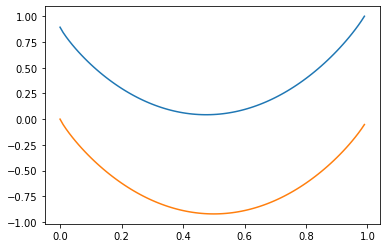

In [14]:
#t = 500
l, s, _, _ = funcs(x, x, tk)

scale = max(max(abs(l)), max(abs(s)))

l /= scale
s /= scale

inp = torch.hstack((l.unsqueeze(0), s.unsqueeze(0)))
print(inp.shape)

plt.plot(x, l)
plt.plot(x, s)
plt.show()

In [7]:
fpd_test = FunctionPairDataset(n_functions=1000, filename="test__.csv", overwrite=True, step=1/in_features)
fpd_test.create_functions()

In [8]:
#d = fpd[6]
d = fpd_test[3]
scale = d[2].unsqueeze(-1)
inp = torch.hstack((d[0][:, 0], d[0][:, 1]))

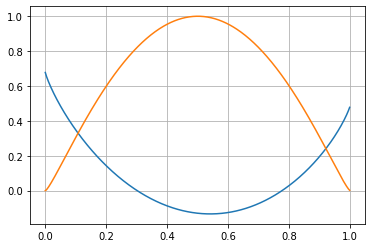

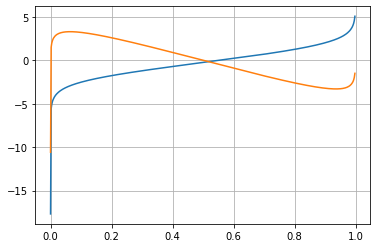

In [9]:
f = fpd.base_function(**d[1][0])/scale
g = fpd.base_function(**d[1][1])/scale
plt.plot(x, f)
plt.plot(x, g)
plt.grid()
plt.show()

f_d = fpd.first_derivative(**d[1][0])/scale
g_d = fpd.first_derivative(**d[1][1])/scale
plt.plot(x, f_d)
plt.plot(x, g_d)
plt.grid()
plt.show()

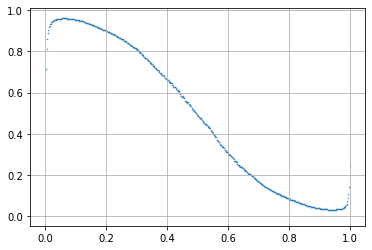

In [10]:
out = net(inp)

plt.scatter(x, out.detach(), s=0.2)
plt.grid()
plt.show()

In [11]:
new_idx = torch.arange(1, 501, step=2)
l_ = torch.index_select(l, 0, new_idx)
x_ = torch.index_select(x, 0, new_idx)
der_1 = net_0(l_)

plt.plot(x_, der_1.detach())
plt.show()

NameError: name 'l' is not defined

82


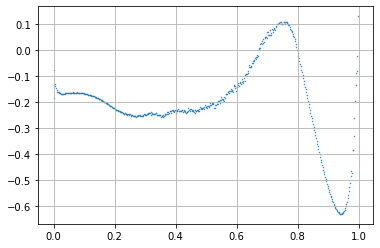

In [597]:
eq = lambda x_, k: (fpd.base_function(**k, x=x_) - x_ * fpd.first_derivative(**k, x=x_))/scale

eqn = (eq(out, d[1][0]) - eq(x, d[1][1]))

i_w_eqn = torch.where(abs(eqn) < 0.1)[0]
print(len(i_w_eqn))
plt.scatter(x, eqn.detach(), s=0.2)
plt.grid()
plt.show()

tensor(0.0151, grad_fn=<MeanBackward0>)
295


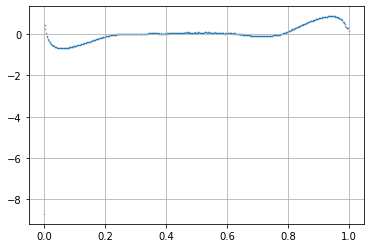

In [598]:
dd = lambda x1, x2: (fpd.first_derivative(**d[1][0],x=x1) - fpd.first_derivative(**d[1][1],x=x2))/scale

diff_der = dd(out, x)
i_w_der = torch.where(abs(diff_der) < 0.1)[0]

print(diff_der.mean())

print(len(i_w_der))

plt.scatter(x, diff_der.detach(), s=.2)
plt.grid()
plt.show()

#diff_der = dd(out, x)/(abs(fpd.first_derivative(**d[1][1], x=x)/scale))
#i_w_der = torch.where(abs(diff_der) < 0.1)[0]

#print(len(i_w_der))

#plt.scatter(x, diff_der.detach(), s=.2)
#plt.grid()
#plt.show()

In [599]:
i_w = torch.tensor([idx_ for idx_ in i_w_eqn if idx_ in i_w_der], dtype=torch.int64)
print(i_w)

tensor([314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327,
        328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341,
        342, 343, 344, 345, 346, 347, 348, 350, 351, 353, 354, 356, 357, 358,
        359, 360, 361, 362, 363, 364, 365, 368, 379, 385, 386, 387, 388, 389,
        390, 391, 392, 393, 394, 395, 396, 397, 398])


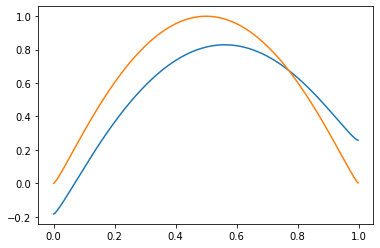

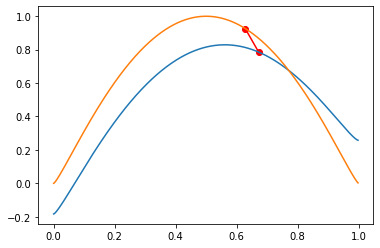

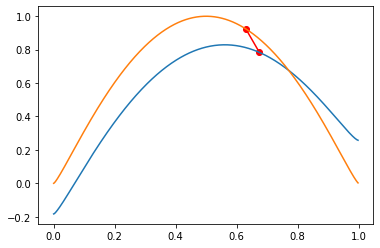

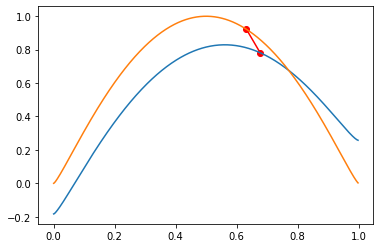

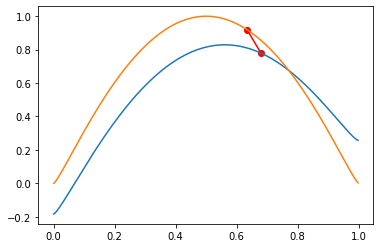

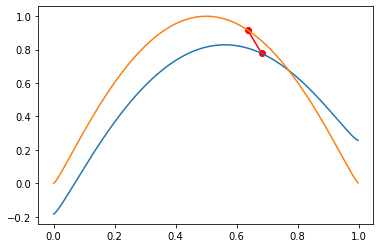

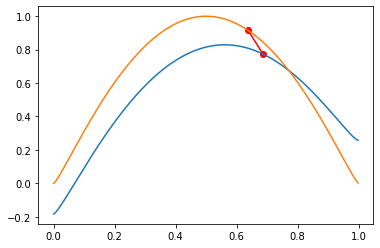

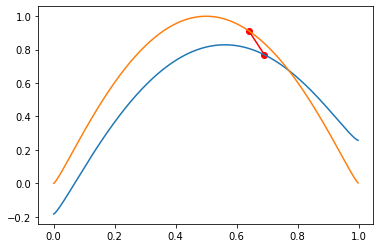

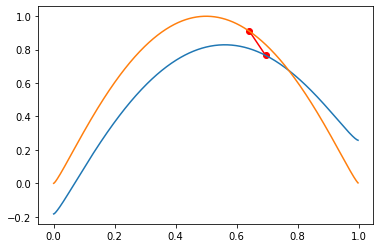

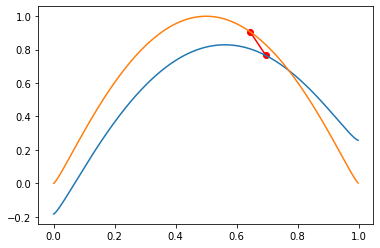

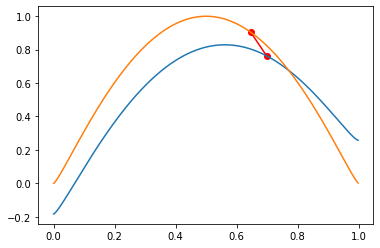

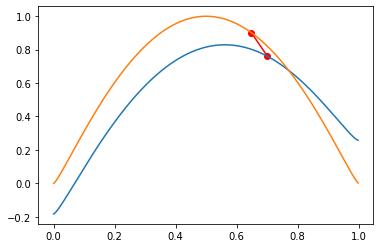

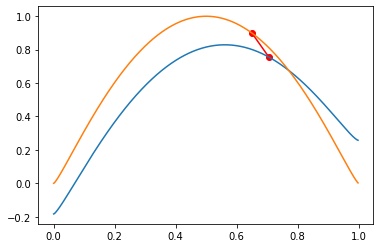

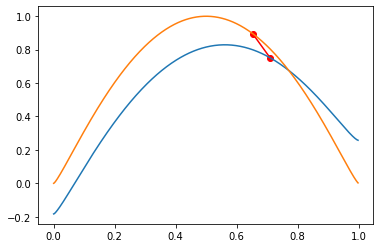

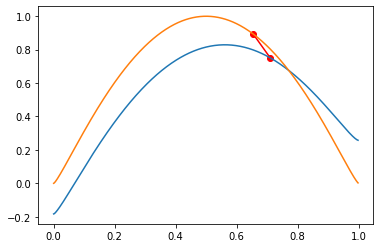

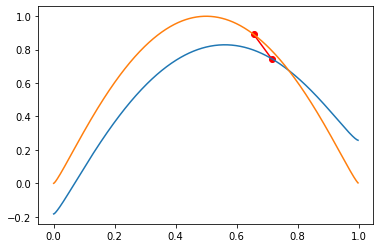

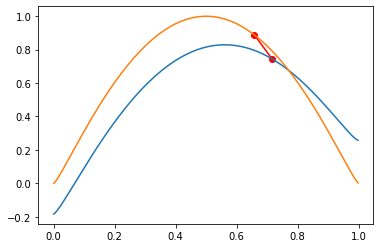

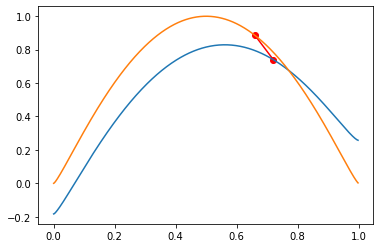

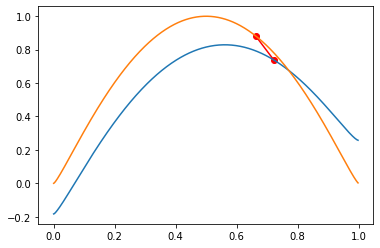

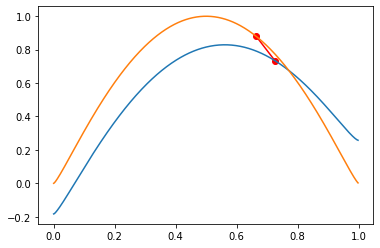

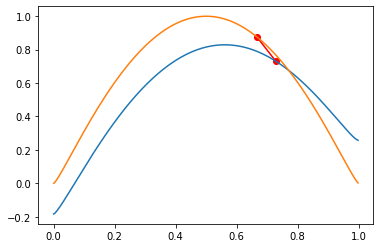

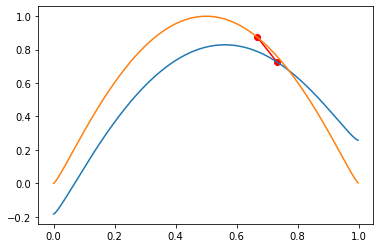

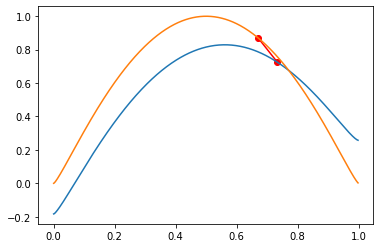

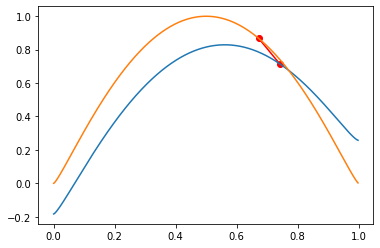

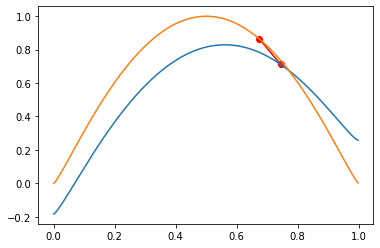

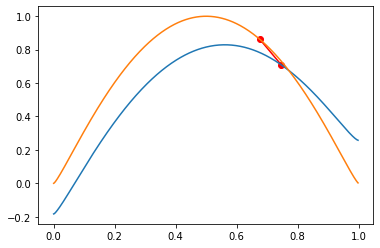

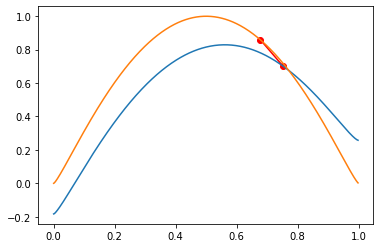

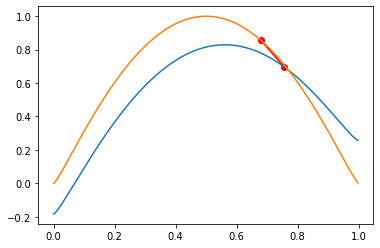

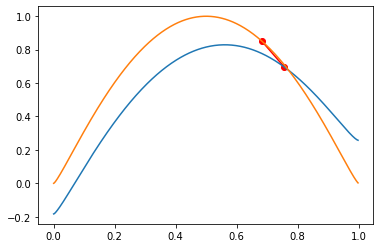

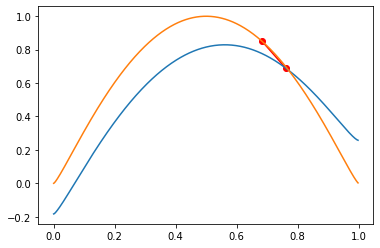

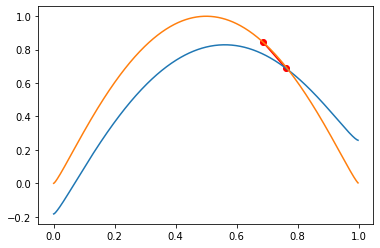

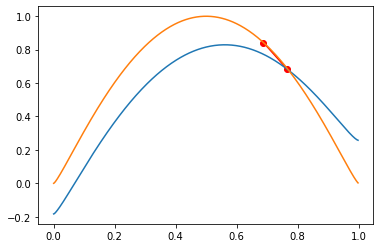

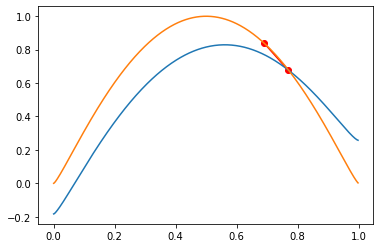

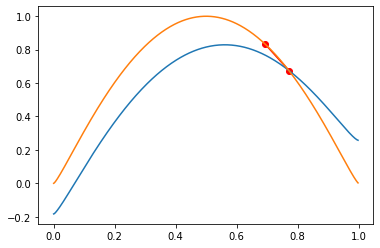

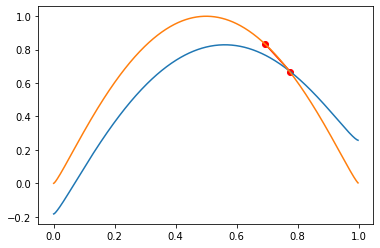

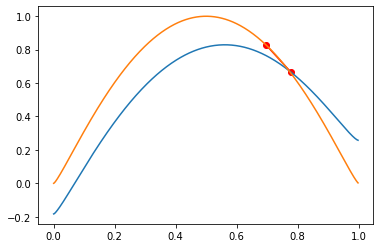

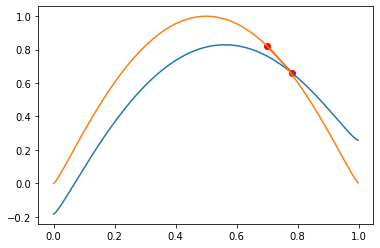

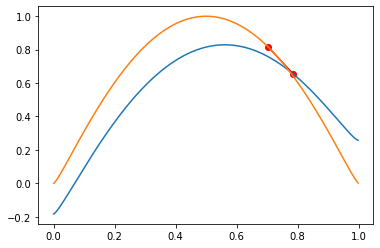

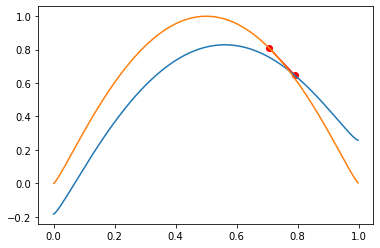

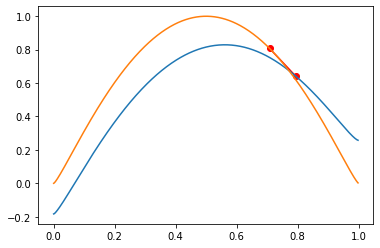

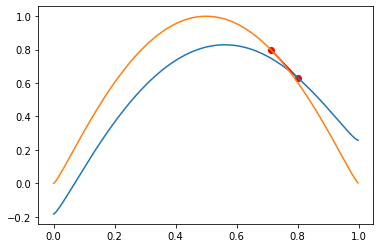

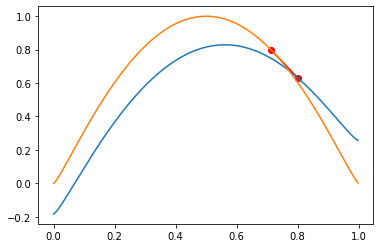

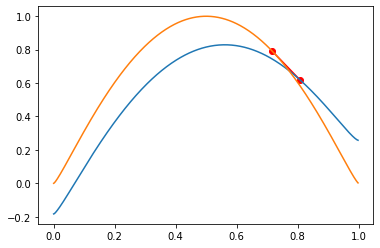

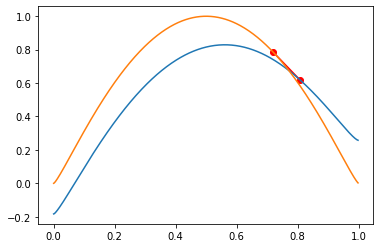

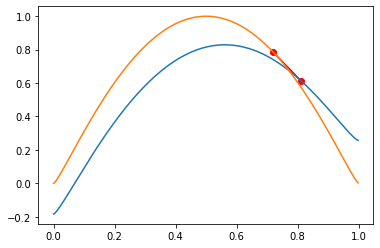

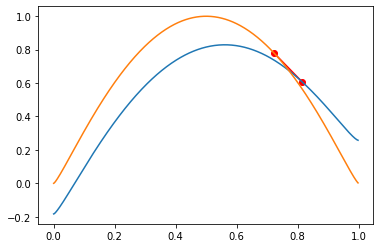

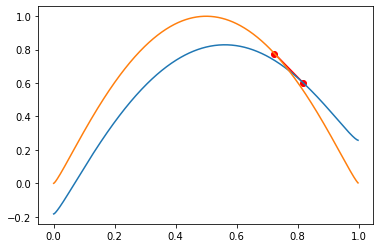

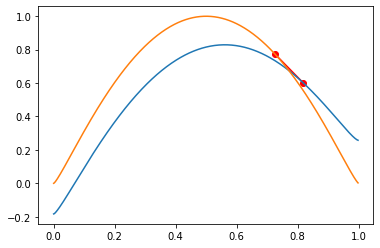

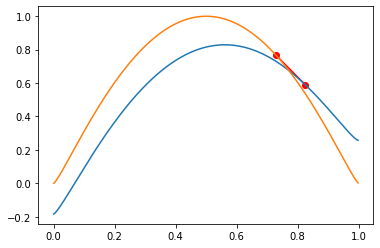

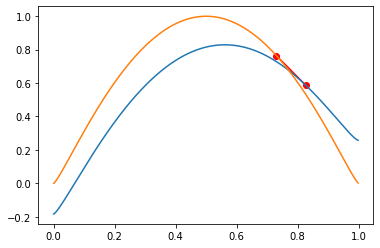

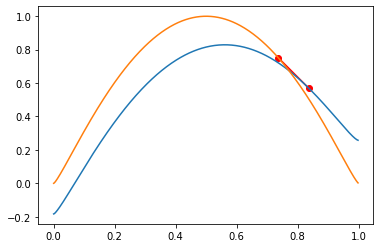

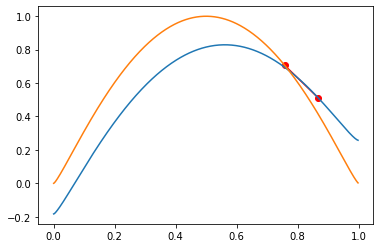

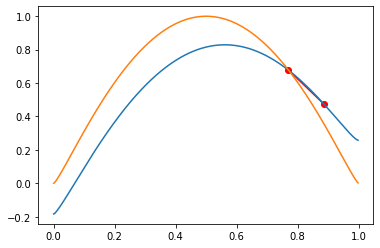

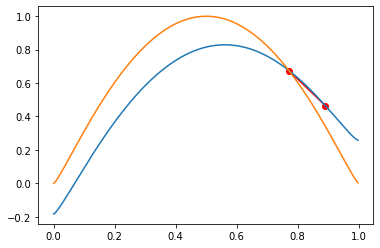

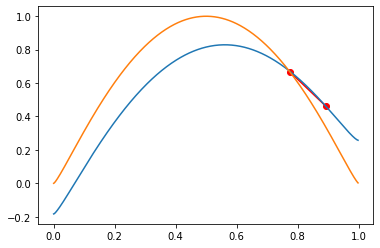

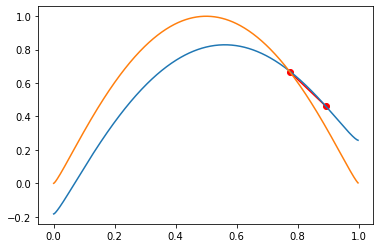

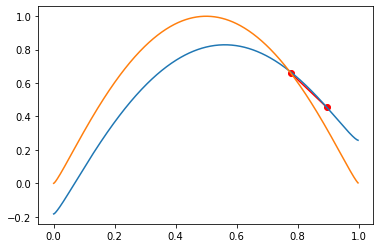

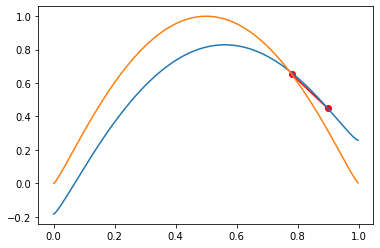

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [600]:
plt.plot(x, f)
plt.plot(x, g)
plt.show()
x_f = out[i_w]
x_g = x[i_w]
y_f = fpd.base_function(**d[1][0], x=x_f)/scale
y_g = fpd.base_function(**d[1][1], x=x_g)/scale

for o, xx, yy, yy_ in zip(x_f.detach(), x_g, y_f.detach(), y_g):
    plt.plot([o, xx], [yy, yy_], 'ro-')
    plt.plot(x, f)
    plt.plot(x, g)
    plt.show()
#plt.show()

In [442]:
print(eq(x_f, d[1][0]) - eq(x_g, d[1][1]))
print(dd(x_f, x_g))

tensor([ 0.0033,  0.0128,  0.0446,  0.0275,  0.0543, -0.0758],
       grad_fn=<SubBackward0>)
tensor([ 0.0286,  0.0111, -0.0444, -0.0284, -0.0718, -0.0842],
       grad_fn=<DivBackward0>)


In [443]:
print((y_g - y_f)/(x_g - x_f))
print(fpd.first_derivative(**d[1][0],x=x_f)/scale)
print(((y_g - y_f)/(x_g - x_f) - fpd.first_derivative(**d[1][0],x=x_f)/scale))

tensor([-0.5036, -0.4893, -0.4463, -0.4786, -0.4406,  0.7235],
       grad_fn=<DivBackward0>)
tensor([-0.5767, -0.5851, -0.6139, -0.5892, -0.6155, -0.3775],
       grad_fn=<DivBackward0>)
tensor([0.0732, 0.0958, 0.1676, 0.1107, 0.1749, 1.1010],
       grad_fn=<SubBackward0>)
